# Part 0: Initializing


In [1]:
# Initializing
import matplotlib.font_manager as font_manager

# from matplotlib.lines import Line2D
import matplotlib as mpl

# import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# import os
import re
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf

# import requests
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

NUM_COLORS = 15
cm = plt.get_cmap("nipy_spectral")

mpl.rcParams.update(params)


import warnings

warnings.filterwarnings("ignore")


To start with, we import three datasets that are available from YouNiverse:

` ` df_channels_en.tsv.gz ` `

` ` df_timeseries_en.tsv.gz ` `

` ` yt_metadata_helper.feather ` `

We filter the channels that have been identified as Gaming, as it is our target category. We do this by identifying the channel IDs with label ` ` Gaming `  ` in `  ` Category `  ` from `  ` df_channels_en.tsv.gz ` ` .


In [2]:
df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])

df_channels = df_channels[df_channels["category_cc"] == "Gaming"]
channel_id_gaming = df_channels.channel


` ` channel_id_gaming `  ` contains all channel IDs that are identified as Gaming. We use this list to do initial filtering of both `  `df_time_series `  ` and `  ` video_metadatas ` ` .


In [3]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
df_time_series = df_time_series[df_time_series["channel"].isin(channel_id_gaming)]


In [4]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
        "display_id",
    ],
)

# we added these two columns for analysis later on
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
video_metadatas = video_metadatas[video_metadatas["channel_id"].isin(channel_id_gaming)]


We now have filtered ` ` df_channels `  ` , `  ` df_time_series `  ` and `  ` video_metadatas `  ` . However, they have a different amount of channels. `  ` df_channels `  ` and `  ` video_metadatas `  ` both have 20143 channels, whereas `  ` df_time_series ` ` has 19698 channels. 

When we take a closer look at the data, we can observe that `df_time_series` only has data from early January 2015 to end September 2019, which could be one reason causing this inconsistency. Therefore, we filter videos in ` ` video_metadatas ` ` that are being uploaded from early January 2015 to end September 2019 to keep consistency across all three dataframes.


In [5]:
video_metadatas = video_metadatas[
    (video_metadatas["upload_date"] > df_time_series.datetime.min())
    & (video_metadatas["upload_date"] < df_time_series.datetime.max())
]


We now have a list of Gaming channels and the information about their videos. Now, we proceed to filter out the channels that fit the following conditions:

* The channel uploads more than 60 % of gaming videos
* The YouTuber uploaded with an average frequency of "every 2 days or less" AND "every 90 days or more"

The justification for these filtering requirements is that we want to have gaming-focused channels that publish videos moderately frequently but not infrequently enough. A single person is unlikely to run a channel with a very high upload frequency, whereas channels with too few uploads are likely to be discontinued. 

We accomplish this filtering by looking at ` ` video_metadatas ` ` , and calculate:

* The number of videos being labelled as "Gaming" in each channel
* The number of videos being uploaded to each channel
* The time frame within which the YouTuber is active (corresponding to the number of days between the first and last upload)


In [6]:
# The number of videos being labelled as "Gaming" in each channel
video_metadatas["is_gaming"] = video_metadatas.categories == "Gaming"

# The number of videos being uploaded to each channel
count_per_channel = (
    pd.DataFrame(video_metadatas.groupby("channel_id").count().categories)
    .reset_index()
    .rename(columns={"categories": "nr_videos"})
)
game_video_count_per_channel = pd.DataFrame(
    video_metadatas.groupby("channel_id").sum().is_gaming
).reset_index()

# merge these two datasets
channel_selection = count_per_channel.merge(game_video_count_per_channel)

# The percentage of gaming videos within each channel
channel_selection["pct_gaming"] = (
    channel_selection.is_gaming / channel_selection.nr_videos
)


In [7]:
pct_level = 0.6  # adjust the percentage of videos being labelled as "Gaming" here
selected_channels = list(
    channel_selection[channel_selection["pct_gaming"] >= pct_level].channel_id
)
channel_selection = channel_selection[
    channel_selection["channel_id"].isin(selected_channels)
]


After performing the filtering over percentage of videos being labelled as "Gaming", we have 18230 channels. 

We now want to filter out the channels that upload videos too frequently or too infrequent:


In [8]:
# The time frame within which the YouTuber is active
last_vid_date = (
    pd.DataFrame(video_metadatas.groupby("channel_id").max().upload_date)
    .reset_index()
    .rename(columns={"upload_date": "last_vid_date"})
)
first_vid_date = (
    pd.DataFrame(video_metadatas.groupby("channel_id").min().upload_date)
    .reset_index()
    .rename(columns={"upload_date": "first_vid_date"})
)
total_vids = (
    pd.DataFrame(video_metadatas.groupby("channel_id").count().display_id)
    .reset_index()
    .rename(columns={"display_id": "total_vids"})
)


In [9]:
channel_selection = first_vid_date.merge(last_vid_date)
channel_selection = channel_selection.merge(total_vids)
channel_selection["active_days"] = (
    channel_selection.last_vid_date - channel_selection.first_vid_date
).dt.days
channel_selection["upload_interval"] = (
    channel_selection.active_days / channel_selection.total_vids
)


In [10]:
min_upload_interval = 2  # in days, the channel upload videos on average every x days
max_upload_interval = 90
selected_channels = list(
    channel_selection[
        (channel_selection["upload_interval"] > min_upload_interval)
        & (channel_selection["upload_interval"] < max_upload_interval)
    ].channel_id
)


Here, we filtered out channels that uploaded videos every 2 days or more often, and those who uploaded videos every 90 days or less frequent. Now we have 14730 channels.

Note that `df_time_series` contains less channels than `df_channels` and `video_metadatas` . In order to keep consistency, we will only look at the channels that can be found across three dataframes.


In [11]:
df_time_series = df_time_series[df_time_series["channel"].isin(selected_channels)]

selected_channels = list(
    df_time_series.groupby("channel").count().reset_index().channel
)


In [12]:
df_channels = df_channels[df_channels["channel"].isin(selected_channels)]

video_metadatas = video_metadatas[video_metadatas["channel_id"].isin(selected_channels)]


After applying the filtering over upload frequency, we now have 14380 channels over all ` `df_time_series `  ` , `  ` df_channels `  ` , and `  `video_metadatas` ` . The filtering is now complete, and we have a final list of channels that we are interested in.


We also import two datasets that are created by us, as a complementary to ` ` video_metadatas ` ` :  
* ``title_metadatas``: with three columns (``categories``, ``display_id``, ``title``), containing information about the title names of each video in ``video_metadatas``.
* ``tag_metadatas``: with three columns (``categories``, ``display_id``, ``tags``), containing information about the tags of each video in ``video_metadatas``.

We filter videos from channels that we selected so far.


In [13]:
title_metadatas = pd.read_feather("./data/yt_metadata_title_helper.feather")

title_metadatas = title_metadatas[
    title_metadatas["display_id"].isin(video_metadatas.display_id)
]


In [14]:
title_metadatas.head()


,categories,display_id,title
1792,Gaming,M0x6TJmMwL4,Blasphemous is Amazing!
1793,Gaming,ofAIp6dad00,I review all 42 Genesis Mini games
1794,Gaming,cXHRNThI27A,Disenchantment Jester Season 2
1795,Gaming,cDSo3mUNEEM,💀 Death Stranding is boring as Hell
1796,Gaming,rJmT1Rq24qE,Happy Friday the 13th. I'm going to try and fi...


In [15]:
tag_metadatas = pd.read_feather("./data/yt_metadata_tags_helper.feather")

tag_metadatas = tag_metadatas[
    tag_metadatas["display_id"].isin(video_metadatas.display_id)
]


In [16]:
tag_metadatas.head()


,categories,display_id,tags
1792,Gaming,M0x6TJmMwL4,"video,games,retrogamer3,ed,findlay,Blasphemous..."
1793,Gaming,ofAIp6dad00,"video,games,retrogamer3,ed,findlay,Sega,Genesi..."
1794,Gaming,cXHRNThI27A,"video,games,retrogamer3,ed,findlay,Disenchantm..."
1795,Gaming,cDSo3mUNEEM,"video,games,retrogamer3,ed,findlay,Death Stran..."
1796,Gaming,rJmT1Rq24qE,"video,games,retrogamer3,ed,findlay,Friday the ..."


# Part 1: Milestone 3 Analysis

Given the results in Milestone 2, we decided to focus on the category of Gaming. The reason behind this choice is because we are trying to help our little brother to succeed, and since he is just a single person without a big team behind him it seems more reasonable than e.g. Movies or Film & Entertainment. Therefore, we decided to eliminate Music, How-to & Style, Education, Science & Technology, Entertainment, Film & Entertainment, People & Blogs, Comedy, Movies and Shows.

## Key Questions:

 - Which factors help a YouTuber in Gaming gain popularity?
 - How does language in titles and tags affect views and how do these relationships change over time?


## Sub-Question 1 

**Description:** How does the video upload frequency, time of the week, and video length affect the subscription rate of the channels?
**Method:** Model this using a linear regression model.  
**Timeline:** By 13/12/2022 


In [17]:
# calculate which weekday each channel usually upload videos
avg_upload_weekday = (
    pd.DataFrame(video_metadatas.groupby("channel_id").mean().weekNumber)
    .reset_index()
    .rename(columns={"weekNumber": "avg_upload_weekday"})
)

# calculate the average video duration of videos uploaded for each channel
avg_video_duration = (
    pd.DataFrame(video_metadatas.groupby("channel_id").mean().duration)
    .reset_index()
    .rename(columns={"duration": "avg_video_duration"})
)


In [18]:
# merge the two dataframes from above, and merge with
channel_selection = channel_selection.merge(avg_upload_weekday)
channel_selection = channel_selection.merge(avg_video_duration)
channel_selection = channel_selection.merge(
    df_channels.loc[:, ["channel", "subscribers_cc"]].rename(
        columns={"channel": "channel_id"}
    )
)


In [19]:
# select the columns from channel_selection for statistical model
model_data = channel_selection.loc[
    :, ["upload_interval", "avg_video_duration", "subscribers_cc"]
]

# normalise the data
xmean = np.mean(model_data, axis=0)
xstd = np.std(model_data, axis=0)
Xbzs = (model_data - xmean) / xstd

# add weekday information
Xbzs = Xbzs.join(
    pd.get_dummies(
        round(channel_selection.avg_upload_weekday).apply(lambda x: int(x)),
        prefix="day",
    )
)


In [20]:
import statsmodels.formula.api as smf

# Declares the model
mod = smf.ols(
    formula="subscribers_cc ~ \
              upload_interval + avg_video_duration + \
              C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         subscribers_cc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     5.293
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           1.19e-06
Time:                        16:02:33   Log-Likelihood:                -20383.
No. Observations:               14380   AIC:                         4.078e+04
Df Residuals:                   14371   BIC:                         4.085e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1583      0

The baseline of the model is: A channel with median upload interval, median average video duration and upload videos usually on Mondays.

| | Number of Subscribers|
| :--- | :---: |
| Intercept | -0.1583 (0.698) |
| Tuesday | 0.0872 (0.842) |
| Wednesday | 0.1919 (0.639) |
| Thursday | 0.1545 (0.705) |
| Friday | 0.1534 (0.707) |
| Saturday | 0.2544 (0.545) |
| Sunday | 0.1731 (0.764) |
| Upload interval | -0.0497 (0.000***) |
| Average video duration | -0.0263 (0.002**) |
| $R^2$ | 0.003 |
| Adj. $R^2$ | 0.002 |
| No. obs. | 14380 |

SEs of coefficients are in parentheses. $^{***}P <0.001$, $^{**}P<0.01$, and $^{*}P<0.05$.

The results from the linear model indicate two statistically significant terms (with significance level of 0.005): upload interval and average video duration. The coefficients of these two terms suggest that:

* the higher the upload interval, the lower the subscription rate
* the higher the average video duration, the lower the subscription rate

On the other hand, it seems that time of upload during the week doesn't have a strong influence on the subscription rate of the channels. However, it should be noted that the average upload date of videos is highly concentrated on Thursday for the selected channels (as seen from the table below), and this would be the reason why the time of upload during the week is not as important.

| Weekday | Number of Channels |
| --- | --- |
| Monday | 6 |
| Tuesday | 40 |
| Wednesday | 1332 |
| Thursday | 11394 |
| Friday | 1501 |
| Saturday | 101 |
| Sunday | 6 |


## Sub-Question 2

**Description:** How does the language used in titles and tags affect video's popularity?  
**Method:** We classify the sentiments of titles and tags using the package spacy and vaderSentiment and try to see if this factor affects view counts of videos using relevant skills we learned in observational studies.  
**Timeline:** By 15/12/2022


In [21]:
# NLP libraries
import spacy, nltk, sklearn

# Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the Spacy analyzer in English
nlp = spacy.load("en_core_web_sm")


We then move on to determine the sentiments of titles, and their effect on the view counts.


In [22]:
positive_sent = []
negative_sent = []
neutral_sent = []
compound_sent = []

# iterate through the sentences, get polarity scores, choose a value
analyzer = SentimentIntensityAnalyzer()
for title in title_metadatas.title:
    score = analyzer.polarity_scores(title)
    positive_sent.append(score["pos"])
    negative_sent.append(score["neg"])
    neutral_sent.append(score["neu"])
    compound_sent.append(score["compound"])

video_metadatas["title_pos_scr"] = positive_sent
video_metadatas["title_neg_scr"] = negative_sent
video_metadatas["title_neu_scr"] = neutral_sent
video_metadatas["title_com_scr"] = compound_sent


In [23]:
# assign each title either as positive, negative or neutral
video_metadatas["pos_vid"] = video_metadatas["title_com_scr"] > (1 - 2 / 3)
video_metadatas["neu_vid"] = (video_metadatas["title_com_scr"] < (1 - 2 / 3)) & (
    video_metadatas["title_com_scr"] > -(1 - 2 / 3)
)
video_metadatas["neg_vid"] = video_metadatas["title_com_scr"] < -(1 - 2 / 3)


In [24]:
# select the data for the model
model_data = video_metadatas.loc[:, ["duration", "view_count"]]

# normalize the data
xmean = np.mean(model_data, axis=0)
xstd = np.std(model_data, axis=0)
Xbzs = (model_data - xmean) / xstd

# add weekday information
Xbzs = Xbzs.join(pd.get_dummies(video_metadatas.weekNumber, prefix="day"))
Xbzs = Xbzs.join(video_metadatas.loc[:, ["pos_vid", "neg_vid"]])

# Declares the model
mod = smf.ols(
    formula="view_count ~ C(pos_vid) + C(neg_vid) + duration + \
              C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     82.12
Date:                Fri, 23 Dec 2022   Prob (F-statistic):          2.91e-153
Time:                        16:45:22   Log-Likelihood:            -4.4539e+06
No. Observations:             3139185   AIC:                         8.908e+06
Df Residuals:                 3139175   BIC:                         8.908e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0074      0

The baseline of the model is: A video with median duration, being uploaded on Mondays, and with neutral titles.

The result shows title sentiment, duration and upload time of the week are all statistically significant when determining view counts of the video. More specifically:
* Videos uploaded between Thursday and Saturday are more likely to have higher view counts
* Showing positive or negative sentiments would increase view counts
* Having longer video duration would decrease view counts

However, from graphs below, we can see that the majority of the videos were classified as "neutral". This suggests that the result of the model will be biased if we run it like this. In order to gain a more balanced idea over the effect of sentiments in titles, we select the videos such that the number of positive, neutral and negative videos are the same.


Text(0.5, 1.0, 'Sentimental Analysis: Distribution')

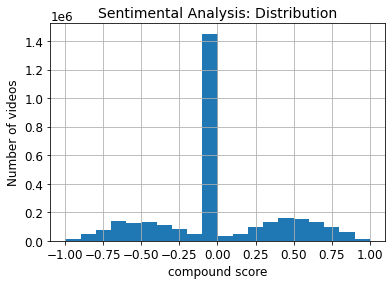

In [25]:
# visualize the result
video_metadatas["title_com_scr"].hist(bins=20)
plt.xlabel("compound score")
plt.ylabel("Number of videos")
plt.title("Sentimental Analysis: Distribution")


The histogram above shows that the majority of the video titles are neutral. Let's now look closer at this by category of videos, since many channels also have videos from categories other than "Gaming".


In [26]:
# get category list
categories_list = np.unique(video_metadatas.categories)
categories_list = categories_list[1:]

# get bin interval
bin_step = np.arange(-1, 1.1, 0.2)

# calculate how many videos of each category fall in the corresponding bin
by_category_data = np.zeros((len(categories_list), len(bin_step) - 1), dtype=int)

for i in np.arange(len(categories_list)):
    by_category_data[i,] = np.histogram(
        video_metadatas[
            video_metadatas["categories"] == categories_list[i]
        ].title_com_scr,
        bins=bin_step,
    )[0]

bin_mid_pt = (bin_step[0:-1] + bin_step[1:]) / 2
bin_mid_pt = [round(item, 2) for item in list(bin_mid_pt)]

# get
data = by_category_data.T / (np.sum(by_category_data, axis=1))


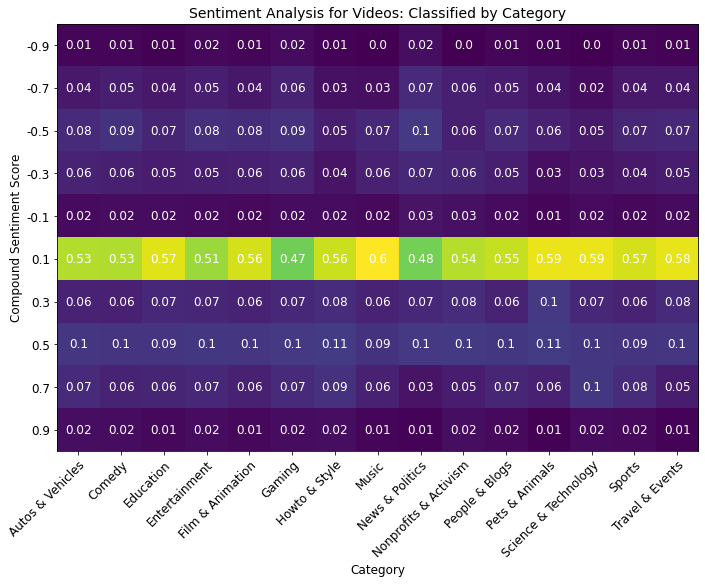

In [27]:
fig, ax = plt.subplots(figsize=(10, 15))
im = ax.imshow(data)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(categories_list)), labels=categories_list)
ax.set_yticks(np.arange(len(bin_mid_pt)), labels=bin_mid_pt)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(bin_mid_pt)):
    for j in range(len(categories_list)):
        text = ax.text(j, i, round(data[i, j], 2), ha="center", va="center", color="w")

ax.set_title("Sentiment Analysis for Videos: Classified by Category")
ax.set_xlabel("Category")
ax.set_ylabel("Compound Sentiment Score")

fig.tight_layout()
plt.show()


The heat map above shows similar information as the histogram, but for all categories of videos in our data sample. It seems that "Gaming" videos are amongst the categories with the lowest share of neutral titles.

We further filter a data sample for the purpose of this analysis, such that the share between videos with positive, negative and neutral titles is more or less the same.


In [28]:
# we will filter the data such that the number of positiv
filtered_metadatas = video_metadatas
pos_vid_ind = np.where(filtered_metadatas["pos_vid"] == True)[0]
neg_vid_ind = np.where(filtered_metadatas["neg_vid"] == True)[0]
neu_vid_ind = np.where(filtered_metadatas["neu_vid"] == True)[0]

sample_size = min(
    [np.shape(neg_vid_ind), np.shape(neu_vid_ind), np.shape(pos_vid_ind)]
)[0]
selected_index = list(random.choices(pos_vid_ind, k=sample_size))
selected_index += list(random.choices(neg_vid_ind, k=sample_size))
selected_index += list(random.choices(neu_vid_ind, k=sample_size))
filtered_metadatas = filtered_metadatas.iloc[selected_index]


After filtering, the data sample seems more balanced, for both sentiments and days of the week:

| Weekday | Number of Videos |
| --- | --- |
| positive titles | 615479 |
| neutral titles | 615479 |
| negative titles | 615479 |
| Monday | 258922 |
| Tuesday | 265411 |
| Wednesday | 270010 |
| Thursday | 268505 |
| Friday | 277740 |
| Saturday | 259516 |
| Sunday | 246333 |

With this, we will proceed with the modelling:


In [29]:
model_data = filtered_metadatas.loc[
    :,
    [
        "duration",
        "view_count",
        "like_count",
        "dislike_count",
    ],
]
# normalise the data
xmean = np.mean(model_data, axis=0)
xstd = np.std(model_data, axis=0)
Xbzs = (model_data - xmean) / xstd

Xbzs = Xbzs.join(pd.get_dummies(filtered_metadatas["weekNumber"], prefix="day"))
Xbzs = Xbzs.join(filtered_metadatas.loc[:, ["pos_vid", "neg_vid"]])


In [30]:
# Declares the model
mod = smf.ols(
    formula="view_count ~ C(pos_vid) + C(neg_vid) + duration + \
    C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             view_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     286.8
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:47:07   Log-Likelihood:            -1.0688e+07
No. Observations:             7034990   AIC:                         2.138e+07
Df Residuals:                 7034980   BIC:                         2.138e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0101      0

In [31]:
# Declares the model
mod = smf.ols(
    formula="like_count ~ C(pos_vid) + C(neg_vid) + duration + \
C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:             like_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     569.7
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:48:42   Log-Likelihood:            -9.9106e+06
No. Observations:             6987891   AIC:                         1.982e+07
Df Residuals:                 6987881   BIC:                         1.982e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0151      0

In [32]:
# Declares the model
mod = smf.ols(
    formula="dislike_count ~ C(pos_vid) + C(neg_vid) + duration + \
C(day_1) + C(day_2) + C(day_3) + C(day_4) + C(day_5) + C(day_6)",
    data=Xbzs,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:          dislike_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     422.4
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:50:15   Log-Likelihood:            -9.8560e+06
No. Observations:             6987891   AIC:                         1.971e+07
Df Residuals:                 6987881   BIC:                         1.971e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.0099      0

The baseline of the model is: A video that is being uploaded on Monday, with neutral titles, and median duration.

|  | View Counts | Like Counts | Dislike Counts |
| :--- | :---: | :---: | :---: |
| Intercept | -0.0204 (0.000***) | -0.0229 (0.000***) | -0.0194 (0.000***) |
| Tuesday | -0.0010 (0.439) | -0.0009 (0.453) | -0.0085 (0.969) |
| Wednesday | 0.0122 (0.000***) | 0.0017 (0.178) | 9.058e-05 (0.953) |
| Thursday |  0.0068 (0.000***) | 0.0013 (0.286) | -0.0030 (0.053) |
| Friday |  0.0101 (0.000***) | 0.0068 (0.000***) | 0.0026 (0.094) |
| Saturday | 0.0260 (0.000***) | 0.0320 (0.000***) | 0.0213 (0.000***) |
| Sunday |  0.0059 (0.000***) | 0.0165 (0.000***) | 0.0150 (0.000***) |
| Positive title | 0.0132 (0.000***) | 0.0140 (0.000***) | 0.0133 (0.000***) |
| Negative title | 0.0157 (0.000***) | 0.0240 (0.000***) | 0.0285 (0.000***) |
| Duration | -0.0178 (0.000***) | -0.0257 (0.000***) | -0.0176 (0.000***) |
| $R^2$ | 0.000 | 0.001 | 0.000 |
| Adj. $R^2$ | 0.000 | 0.001 | 0.000 |
| No. obs. | 7040768 | 6994858 | 6994858 |

SEs of coefficients are in parentheses. $^{***}P <0.001$, $^{**}P<0.01$, and $^{*}P<0.05$.


The result shows title sentiment, duration and upload time of the week are all statistically significant when determining view counts of the video. This alligns with the result from previous model. More specifically:
* Videos uploaded on Wednesdays, Fridays and Saturdays are more likely to have higher view counts  
* Showing positive or negative sentiments would increase view counts compared with neutral sentiments, like counts and dislike counts. Comparing to positive sentiments, showing negative sentiments seems to attract more view counts, more likes and dislikes.
* Having longer video duration would decrease view counts, like counts and dislike counts.


---


### Analysis of the effect of casefolding in titles and tags


To go one step further, we investigate the relationship between the number of views and the titles (length, sentiment, casefold, etc...). For this purpose we use an observational study approach in order to be able to compare among channels. We keep the channel id to see the number of subscriptions of the channel and compare pairwise similar to the number of subscriptions.


In [33]:
title_metadatas = pd.read_feather("./data/yt_metadata_title_filtered.feather")


In [34]:
title_metadatas.drop(["index", "categories"], axis=1, inplace=True)


In [35]:
metadatas = pd.merge(video_metadatas, title_metadatas, on="display_id")


In [36]:
metadatas.head(2)


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,is_gaming,title_pos_scr,title_neg_scr,title_neu_scr,title_com_scr,pos_vid,neu_vid,neg_vid,title
0,Gaming,2019-09-29,892,58.0,3.0,584.0,UCzWm1-4XF7AHxVUTkHCM1uw,M0x6TJmMwL4,2019,6,True,0.672,0.0,0.328,0.6239,True,False,False,Blasphemous is Amazing!
1,Gaming,2019-09-22,2428,60.0,11.0,1023.0,UCzWm1-4XF7AHxVUTkHCM1uw,ofAIp6dad00,2019,6,True,0.000,0.0,1.000,0.0000,False,True,False,I review all 42 Genesis Mini games


Distribution of weekdays upload dates


Text(0, 0.5, 'Number of videos')

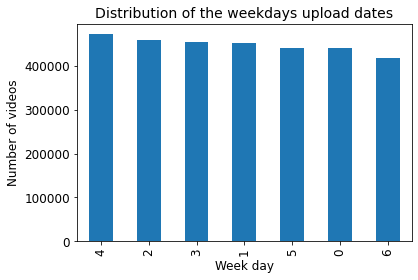

In [37]:
metadatas.weekNumber.value_counts().plot(kind="bar")
plt.title("Distribution of the weekdays upload dates")
plt.xlabel("Week day")
plt.ylabel("Number of videos")


In [38]:
# we need to improve the hw1 method a bit because we want to make sure that titles with a lot of spaces
# don't have too many words and if there is a typo (e.g "Welcome,in my video" should be counted as 4 words and not 3)
def count_words(x: str):
    new_x = x.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip()
    return len(new_x.split(" "))


def get_freq_capital_words(sentence: str):
    new_x = sentence.replace(",", " ")
    # change anything that isn’t an alphanumeric character or whitespace, and replaces it with a space
    new_x = re.sub(r"[^\w\s]", " ", new_x)
    # Change many consecutive spaces into a single space
    new_x = re.sub(" +", " ", new_x)
    # delete begin/end spaces
    new_x = new_x.strip().split(" ")
    nb_capital_words = 0
    for word in new_x:
        if word.isupper():
            nb_capital_words += 1
    return nb_capital_words / len(new_x)


In [39]:
# test the function
print(count_words("Salut     je suis la"))
print(count_words("Salut,je suis la"))
print(count_words("#FuckCancer | I'VE GOT SOME GREAT NEWS!"))
print(count_words("DISNEY CHRISTMAS VLOG! || Zak Longo"))
print(count_words("Sims 4 - SHOOTING SIMS WITH A GUN - The Sims 4"))
print(count_words("###ADA#ada##"))

# test capitalize words function
print(get_freq_capital_words("Sims 4 - SHOOTING SIMS WITH A GUN - The Sims 4"))
print(get_freq_capital_words("###ADA###salut|||test&SALUT"))


4
4
7
5
10
2
0.5
0.5


In [40]:
metadatas["title_nb_words"] = metadatas.title.apply(lambda title: count_words(title))


In [41]:
metadatas["freq_capitalize_words"] = metadatas.title.apply(
    lambda title: get_freq_capital_words(title)
)


In [42]:
metadatas.head()


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,...,title_pos_scr,title_neg_scr,title_neu_scr,title_com_scr,pos_vid,neu_vid,neg_vid,title,title_nb_words,freq_capitalize_words
0,Gaming,2019-09-29,892,58.0,3.0,584.0,UCzWm1-4XF7AHxVUTkHCM1uw,M0x6TJmMwL4,2019,6,...,0.672,0.00,0.328,0.6239,True,False,False,Blasphemous is Amazing!,3,0.000000
1,Gaming,2019-09-22,2428,60.0,11.0,1023.0,UCzWm1-4XF7AHxVUTkHCM1uw,ofAIp6dad00,2019,6,...,0.000,0.00,1.000,0.0000,False,True,False,I review all 42 Genesis Mini games,7,0.142857
2,Gaming,2019-09-20,18,32.0,0.0,2000.0,UCzWm1-4XF7AHxVUTkHCM1uw,cXHRNThI27A,2019,4,...,0.000,0.00,1.000,0.0000,False,True,False,Disenchantment Jester Season 2,4,0.000000
3,Gaming,2019-09-17,587,311.0,116.0,5102.0,UCzWm1-4XF7AHxVUTkHCM1uw,cDSo3mUNEEM,2019,1,...,0.000,0.73,0.270,-0.8957,False,False,True,💀 Death Stranding is boring as Hell,6,0.000000
4,Gaming,2019-09-13,220,35.0,3.0,300.0,UCzWm1-4XF7AHxVUTkHCM1uw,rJmT1Rq24qE,2019,4,...,0.198,0.00,0.802,0.5719,True,False,False,Happy Friday the 13th. I'm going to try and fi...,17,0.058824


Text(0, 0.5, 'nb of titles')

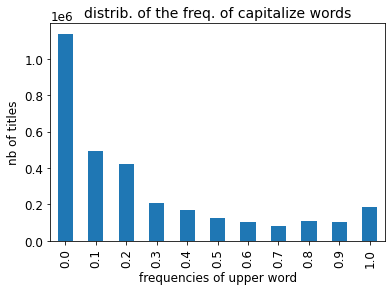

In [43]:
# distrib of the freq capitalize words
# process for the plot
freq_capit_words = round(metadatas.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [44]:
freq_capit_words.value_counts().sort_index()

0.0    1137147
0.1     493490
0.2     420310
0.3     209233
0.4     170436
0.5     127063
0.6     105146
0.7      80171
0.8     110418
0.9     101999
1.0     183773
Name: freq_capitalize_words, dtype: int64

In [45]:
# Calculate the log of the view count, ignoring records where the view count is 0
metadatas["view_count_log"] = np.log(
    metadatas.view_count, where=metadatas.view_count != 0
)

# Create a model using the OLS (Ordinary Least Squares) method to predict the view count
# given the nb of words and frequence of capitalized words in title.
mod = smf.ols(
    formula="view_count_log ~ title_nb_words + freq_capitalize_words", data=metadatas
)

# Fit the model to the data
res = mod.fit()

# Print a summary of the model's results
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         view_count_log   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                 1.040e+04
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:51:46   Log-Likelihood:            -7.2584e+06
No. Observations:             3139185   AIC:                         1.452e+07
Df Residuals:                 3139182   BIC:                         1.452e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 8.21

The frequency of capitalized words in the titles is significant and it increases the number of views on the video. The number of words in the title is significant as well, but the effect size on the number of views is small.


In [46]:
# use a threshold (0.3) to differentiate lower to upper titles
# less than 0.3 is considered as lower title.
lower_title_df = metadatas[metadatas["freq_capitalize_words"] < 0.3]
upper_title_df = metadatas[metadatas["freq_capitalize_words"] >= 0.3]

print("# of upper words title", upper_title_df.shape)
print("# of lower words title", lower_title_df.shape)


# of upper words title (1009630, 22)
# of lower words title (2129556, 22)


For more readability, 1st => Take videos with less than 200 000 views


In [47]:
# round the view count to create bins
lower_title_df.view_count = round(lower_title_df.view_count, -4)
lower_title_count = lower_title_df.view_count.value_counts().sort_index().iloc[150:180]
upper_title_df.view_count = round(upper_title_df.view_count, -4)
upper_title_count = upper_title_df.view_count.value_counts().sort_index().iloc[150:180]


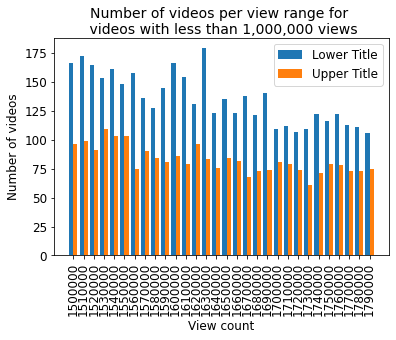

In [48]:
X_axis = np.arange(len(lower_title_count.index))

plt.bar(X_axis - 0.2, lower_title_count.values, 0.4, label="Lower Title")
plt.bar(X_axis + 0.2, upper_title_count.values, 0.4, label="Upper Title")

# plt.xticks(X_axis, lower_title_count.index)
positions = lower_title_count.index
labels = [str(int(pos)) for pos in positions]
plt.xticks(X_axis, labels, rotation="vertical")
plt.title(
    "Number of videos per view range for \n videos with less than 1,000,000 views",
    wrap=True,
)
plt.xlabel("View count")
plt.ylabel("Number of videos")
plt.legend()
plt.show()


### Now match and compare the channels with ~ the same number of subscribers


In [49]:
# retrieve channels with lower < nb of subs < upper
def get_sample_meta(lower, upper):
    return df_channels[
        (df_channels.subscribers_cc > lower) & (df_channels.subscribers_cc < upper)
    ]


### Impact of capitalized words in title for channels with more than 1 M of subscribers


In [50]:
sample_channels = get_sample_meta(1_000_000, 10_000_000)
sample_channels.shape


(303, 8)

In [51]:
sample_metadatas = metadatas[metadatas.channel_id.isin(sample_channels.channel)]

print(sample_metadatas.shape)
len(sample_metadatas.groupby("channel_id").count())


(94390, 22)


303

Text(0, 0.5, 'nb of titles')

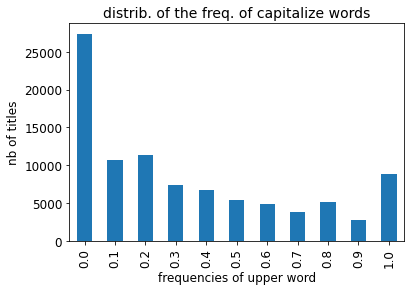

In [52]:
# plot the distrib of the frequ of capitalize words for channels with more than 1M subs
freq_capit_words = round(sample_metadatas.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [53]:
# check the full upper titles and full lowers ones
binary_freq_df = sample_metadatas[
    (sample_metadatas.freq_capitalize_words == 0)
    | (sample_metadatas.freq_capitalize_words == 1)
]

full_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 1]
no_upper_word_df = binary_freq_df[binary_freq_df["freq_capitalize_words"] == 0]

print("# of full upper words title", full_upper_word_df.shape)
print("# of full lower words title", no_upper_word_df.shape)


# of full upper words title (8852, 22)
# of full lower words title (27363, 22)


In [54]:
# create model to predict view count given the nb of words in the title and the frequencies of capitalize words
mod = smf.ols(
    formula="view_count_log ~ title_nb_words + freq_capitalize_words",
    data=sample_metadatas,
)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         view_count_log   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     174.4
Date:                Fri, 23 Dec 2022   Prob (F-statistic):           2.39e-76
Time:                        16:51:59   Log-Likelihood:            -1.8555e+05
No. Observations:               94390   AIC:                         3.711e+05
Df Residuals:                   94387   BIC:                         3.711e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                12.65

The impact is less important if we filter the channels on the number of subscribers but it still it helps to get more views.


In [55]:
# create model to predict view count but for smaller channels now
sample_channels = get_sample_meta(0, 50_000)
sample_metadatas = metadatas[metadatas.channel_id.isin(sample_channels.channel)]
mod = smf.ols(
    formula="view_count_log ~ title_nb_words + freq_capitalize_words",
    data=sample_metadatas,
)
res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:         view_count_log   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     7697.
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:52:02   Log-Likelihood:            -3.7336e+06
No. Observations:             1735396   AIC:                         7.467e+06
Df Residuals:                 1735393   BIC:                         7.467e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 7.06

The impact of capitalized words is more important for channels with more than 1M subscribers compared to channels with less than 50K subscribers. However the effect size on the number of views is still positive.  


Let's plot the upper and lower case titles for big channels (> 100 000 subs) together with the smaller channels.

In [56]:
# split 'big' and 'small' channels
big_channels = df_channels[df_channels.subscribers_cc > 100_000]
little_channels = df_channels[df_channels.subscribers_cc <= 100_000]

print(big_channels.shape)
print(little_channels.shape)


(3586, 8)
(10794, 8)


In [57]:
big_videos_meta = metadatas[metadatas.channel_id.isin(big_channels.channel)]
little_videos_meta = metadatas[metadatas.channel_id.isin(little_channels.channel)]


#### What is the proportion of capitalized titles for big ( > 100 000 subs) vs small (< 100 000 subs) channels


Text(0, 0.5, 'nb of titles')

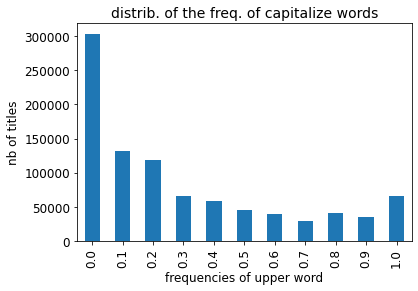

In [58]:
# plot the distrib of the frequ of capitalize words for big channels
freq_capit_words = round(big_videos_meta.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [59]:
# for big channels, calculate the number of titles with more than 0.5 as freq capitalized words (considered as upper titles)
# and divide by the total number of videos
percentage_upper_titles = (
    freq_capit_words.value_counts().sort_index().iloc[-6:].sum()
    / freq_capit_words.value_counts().sum()
    * 100
)

print("Big channels have {:.2f}% of upper titles ".format(percentage_upper_titles))
print(
    "Big channels have {:.2f}% of lower titles ".format(100 - percentage_upper_titles)
)


Big channels have 27.25% of upper titles 
Big channels have 72.75% of lower titles 


Text(0, 0.5, 'nb of titles')

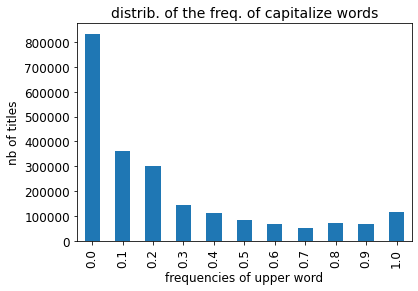

In [60]:
# plot the distrib of the frequ of capitalize words for small channels
freq_capit_words = round(little_videos_meta.freq_capitalize_words, 1)
values_counts = freq_capit_words.value_counts().sort_index()
values_counts.plot(kind="bar")
plt.title("distrib. of the freq. of capitalize words")
plt.xlabel("frequencies of upper word")
plt.ylabel("nb of titles")


In [61]:
# for smaller channels, calculate the number of titles with more than 0.5 as freq capitalized words (considered as upper titles)
# and divide by the total number of videos
percentage_upper_titles = (
    freq_capit_words.value_counts().sort_index().iloc[-6:].sum()
    / freq_capit_words.value_counts().sum()
    * 100
)

print("Small channels have {:.2f}% of upper titles ".format(percentage_upper_titles))
print(
    "Small channels have {:.2f}% of lower titles ".format(100 - percentage_upper_titles)
)


Small channels have 20.60% of upper titles 
Small channels have 79.40% of lower titles 


## Sub-Question 3

**Description:** Can we predict the channel's success based on channel information, including average video length, upload frequency, usual time of uploads, categories of videos uploaded, positive/negative sentiments of the title, person pronouns to address the viewers, the number of words in the title, and the number of tags used?

**Method:** We implement kNN method or Random Forests to train the dataset.  
**Timeline:** By 13/12/2022  


In [62]:
video_metadatas["duration_min"] = video_metadatas["duration"] / 60


Add a column for the day of the week of the upload date for the video


In [63]:
video_metadatas["week_number_mean"] = video_metadatas.groupby("channel_id")[
    "weekNumber"
].transform("mean")

video_metadatas["week_number_mean"] = video_metadatas["week_number_mean"].astype("int")
video_metadatas["mean_duration_min"] = video_metadatas.groupby("channel_id")[
    "duration_min"
].transform("mean")


### Process the dataset and combine them to get all the necessaries informations 


In [64]:
def get_nb_unique_cat(x):
    return x.nunique()


def get_cat(x):
    return list(x.unique())


In [65]:
video_metadatas["nb_diff_cat"] = video_metadatas.groupby("channel_id")[
    "categories"
].transform(get_nb_unique_cat)

cat_per_channels = (
    video_metadatas.groupby("channel_id")["categories"].unique().to_frame()
)


In [66]:
cat_per_channels = cat_per_channels.reset_index()
cat_per_channels = cat_per_channels.rename({"categories": "covered_categories"}, axis=1)
cat_per_channels.head(2)


,channel_id,covered_categories
0,UC--7oyGW0N7fMf164-ZXljQ,"[Gaming, Education, Music, People & Blogs]"
1,UC--b720KocplK9zh0peruqg,"[Gaming, People & Blogs]"


In [67]:
video_metadatas = pd.merge(video_metadatas, cat_per_channels, on="channel_id")


In [68]:
# group by channels and week of upload date to calculate the mean upload frequencies of the channels
grouped = video_metadatas.groupby(
    ["channel_id", pd.Grouper(key="upload_date", freq="W")]
).size()


In [69]:
week_frequency_mean = (
    grouped.groupby(level="channel_id").mean().to_frame().reset_index()
)
week_frequency_mean = week_frequency_mean.rename(columns={0: "week_frequency_mean"})
video_metadatas = pd.merge(video_metadatas, week_frequency_mean, on="channel_id")
week_frequency_mean


,channel_id,week_frequency_mean
0,UC--7oyGW0N7fMf164-ZXljQ,5.911765
1,UC--b720KocplK9zh0peruqg,1.187500
2,UC--vL4ZYLa0bi3TQcuwrhoA,1.533333
3,UC-05oNebNywp5jy7iXZWZzA,2.137097
4,UC-0xJTkutOCoRoBi3YOkHRg,2.511111
...,...,...
14375,UCzyfkcDsgePLd09B-8LxX0g,1.511111
14376,UCzyu0YDMQB_5iSGPOXECcHQ,1.428571
14377,UCzz9_nzdbrxnErTZPZdZ-cw,4.116883
14378,UCzzHicLcWJP2jagxpqebzsA,1.954545


In [70]:
video_metadatas["title_com_scr_mean"] = video_metadatas.groupby("channel_id")[
    "title_com_scr"
].transform("mean")


In [72]:
video_metadatas["title_nb_words_mean"] = metadatas.groupby("channel_id")[
    "title_nb_words"
].transform("mean")


Now find the pronouns in the title


In [74]:
feature_wordsets = dict(
    [
        # https://en.wikipedia.org/wiki/English_personal_pronouns
        (
            "first_person_singular",
            [
                "i",
                "me",
                "my",
                "mine",
                "myself",
                "i'd",
                "i'll",
                "i'm",
                "i've",
                "id",
                "im",
                "ive",
            ],
        ),
        (
            "first_person_plural",
            [
                "we",
                "us",
                "our",
                "ours",
                "ourselves",
                "we'd",
                "we'll",
                "we're",
                "we've",
            ],
        ),
        (
            "second_person",
            [
                "you",
                "your",
                "yours",
                "yourself",
                "ya",
                "you'd",
                "you'll",
                "you're",
                "you've",
                "youll",
                "youre",
                "youve",
                "yourselves",
            ],
        ),
        (
            "third_person_singular",
            [
                "he",
                "him",
                "his",
                "himself",
                "he'd",
                "he's",
                "hes",
                "she",
                "her",
                "hers",
                "herself",
                "she'll",
                "she's",
                "shes",
                "it",
                "its",
                "itself",
                "themself",
            ],
        ),
        (
            "third_person_plural",
            [
                "they",
                "them",
                "their",
                "theirs",
                "themselves",
                "they'd",
                "they'll",
                "they've",
                "theyll",
                "theyve",
            ],
        ),
    ]
)


In [75]:
def get_new_columns_pronouns(feature_wordsets, df, colname):
    dict_pronoun_list = dict(
        [
            ("first_person_singular", []),
            ("first_person_plural", []),
            ("second_person", []),
            ("third_person_singular", []),
            ("third_person_plural", []),
        ]
    )
    for headline in df[colname]:
        headline = headline.lower()
        for key in feature_wordsets.keys():
            # if a word corresponding to a pronoun is present in the headline,
            # then add 1 to this pronoun list (column) otherwise add 0
            if any(
                re.search(r"\b" + pronoun + r"\b", headline)
                for pronoun in feature_wordsets[key]
            ):
                dict_pronoun_list[key].append(1)
            else:
                dict_pronoun_list[key].append(0)
    return dict_pronoun_list


dict_pronoun_list = get_new_columns_pronouns(feature_wordsets, title_metadatas, "title")

# create the new columns in our dataframe
for col in dict_pronoun_list.keys():
    title_metadatas[col] = dict_pronoun_list[col]
title_metadatas.head(3)


,display_id,title,first_person_singular,first_person_plural,second_person,third_person_singular,third_person_plural
0,M0x6TJmMwL4,Blasphemous is Amazing!,0,0,0,0,0
1,ofAIp6dad00,I review all 42 Genesis Mini games,1,0,0,0,0
2,cXHRNThI27A,Disenchantment Jester Season 2,0,0,0,0,0


In [76]:
title_metadatas_without_titles = title_metadatas.drop("title", axis=1)
title_metadatas_without_titles

video_metadatas = pd.merge(
    video_metadatas, title_metadatas_without_titles, on="display_id"
)


In [77]:
df_channels_filtered = df_channels[["channel", "subscriber_rank_sb", "videos_cc"]]

df_channels_filtered = df_channels_filtered.rename({"channel": "channel_id"}, axis=1)
df_channels_filtered.head(2)


,channel_id,subscriber_rank_sb,videos_cc
10,UCEdvpU2pFRCVqU6yIPyTpMQ,18.0,366
42,UCKqH_9mk1waLgBiL2vT5b9g,87.0,1079


In [80]:
full_metadatas = video_metadatas
pd.options.display.max_columns = None
full_metadatas.head()


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber,is_gaming,title_pos_scr,title_neg_scr,title_neu_scr,title_com_scr,pos_vid,neu_vid,neg_vid,duration_min,week_number_mean,mean_duration_min,nb_diff_cat,covered_categories,week_frequency_mean,title_com_scr_mean,title_nb_words_mean,first_person_singular,first_person_plural,second_person,third_person_singular,third_person_plural
0,Gaming,2019-09-29,892,58.0,3.0,584.0,UCzWm1-4XF7AHxVUTkHCM1uw,M0x6TJmMwL4,2019,6,True,0.672,0.00,0.328,0.6239,True,False,False,14.866667,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,0,0,0,0,0
1,Gaming,2019-09-22,2428,60.0,11.0,1023.0,UCzWm1-4XF7AHxVUTkHCM1uw,ofAIp6dad00,2019,6,True,0.000,0.00,1.000,0.0000,False,True,False,40.466667,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,1,0,0,0,0
2,Gaming,2019-09-20,18,32.0,0.0,2000.0,UCzWm1-4XF7AHxVUTkHCM1uw,cXHRNThI27A,2019,4,True,0.000,0.00,1.000,0.0000,False,True,False,0.300000,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,0,0,0,0,0
3,Gaming,2019-09-17,587,311.0,116.0,5102.0,UCzWm1-4XF7AHxVUTkHCM1uw,cDSo3mUNEEM,2019,1,True,0.000,0.73,0.270,-0.8957,False,False,True,9.783333,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,0,0,0,0,0
4,Gaming,2019-09-13,220,35.0,3.0,300.0,UCzWm1-4XF7AHxVUTkHCM1uw,rJmT1Rq24qE,2019,4,True,0.198,0.00,0.802,0.5719,True,False,False,3.666667,3,32.436631,2,"[Gaming, News & Politics]",1.472441,-0.019817,6.090909,1,0,0,0,0


In [81]:
full_metadatas = pd.merge(df_channels_filtered, full_metadatas, on="channel_id")


In [82]:
full_metadatas.head(2)


,channel_id,subscriber_rank_sb,videos_cc,categories,upload_date,duration,like_count,dislike_count,view_count,display_id,yearNumber,weekNumber,is_gaming,title_pos_scr,title_neg_scr,title_neu_scr,title_com_scr,pos_vid,neu_vid,neg_vid,duration_min,week_number_mean,mean_duration_min,nb_diff_cat,covered_categories,week_frequency_mean,title_com_scr_mean,title_nb_words_mean,first_person_singular,first_person_plural,second_person,third_person_singular,third_person_plural
0,UCEdvpU2pFRCVqU6yIPyTpMQ,18.0,366,Music,2019-09-25,67,19158.0,406.0,356370.0,j8vXlZcWydI,2019,2,False,0.355,0.0,0.645,0.6705,True,False,False,1.116667,2,3.623577,8,"[Music, Entertainment, Howto & Style, Gaming, ...",2.58042,0.105691,8.663957,0,0,0,0,0
1,UCEdvpU2pFRCVqU6yIPyTpMQ,18.0,366,Music,2019-09-24,109,14922.0,354.0,292894.0,IkzyCx9hlFs,2019,1,False,0.000,0.0,1.000,0.0000,False,True,False,1.816667,2,3.623577,8,"[Music, Entertainment, Howto & Style, Gaming, ...",2.58042,0.105691,8.663957,0,0,0,0,0


In [83]:
dataset = full_metadatas.groupby("channel_id").apply(
    lambda group: pd.DataFrame(
        {
            "subscriber_rank_sb": group.subscriber_rank_sb.mean(),
            "videos_cc": group.videos_cc.mean(),
            "week_number_mean": group.week_number_mean.values[0],
            "mean_duration_min": group.mean_duration_min.values[0],
            "nb_diff_cat": group.nb_diff_cat.values[0],
            "covered_categories": group.covered_categories.to_frame().values[0],
            "week_frequency_mean": group.week_frequency_mean.values[0],
            "title_com_scr_mean": group.title_com_scr_mean.values[0],
            "title_nb_words_mean": group.title_nb_words_mean.values[0],
            "first_person_singular_mean": group.first_person_singular.mean(),
            "first_person_plural_mean": group.first_person_plural.mean(),
            "second_person_mean": group.second_person.mean(),
            "third_person_singular_mean": group.third_person_singular.mean(),
            "third_person_plural_mean": group.third_person_plural.mean(),
        }
    )
)


In [85]:
data = pd.get_dummies(video_metadatas["weekNumber"], prefix="day").sum()
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]


Text(0.5, 1.0, 'The Number of Videos Uploaded on each Weekday')

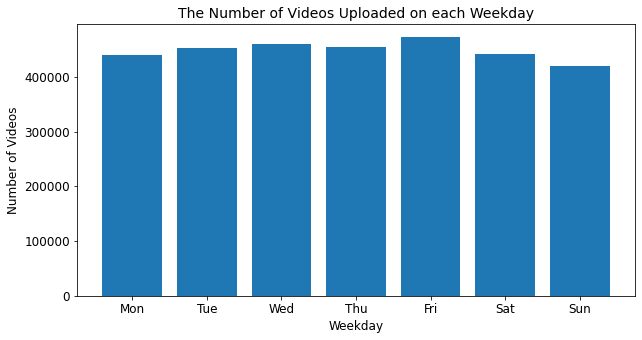

In [86]:
plt.figure(figsize=(10, 5))
plt.bar(day, list(data))
plt.xlabel("Weekday")
plt.ylabel("Number of Videos")
plt.title("The Number of Videos Uploaded on each Weekday")


on average most of the upload dates are on Thursday or Wednesday 


<AxesSubplot:>

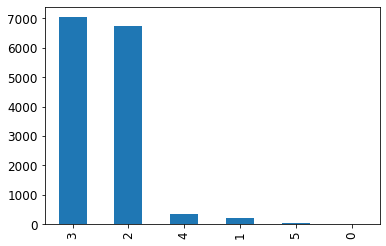

In [87]:
dataset.week_number_mean.value_counts().plot(kind="bar")


### Try to find meaningful features for well ranked channels (rank < 30 000)


In [88]:
dataset.subscriber_rank_sb.median()


364596.0

In [89]:
dataset["well_ranked"] = np.where(dataset.subscriber_rank_sb < 30_000, 1, 0)


In [90]:
dataset.sample()


,,subscriber_rank_sb,videos_cc,week_number_mean,mean_duration_min,nb_diff_cat,covered_categories,week_frequency_mean,title_com_scr_mean,title_nb_words_mean,first_person_singular_mean,first_person_plural_mean,second_person_mean,third_person_singular_mean,third_person_plural_mean,well_ranked
channel_id,,,,,,,,,,,,,,,,
UCutLak8iD_JjUotNmPfInVw,0,540008.0,338.0,3,8.619753,1,[Gaming],1.588235,0.044727,9.422222,0.003704,0.003704,0.003704,0.0,0.0,0


### Using random forest tree with over sampling


In [91]:
# Use over sampling technique
from imblearn.over_sampling import SMOTE

X = dataset.loc[
    :,
    [
        "videos_cc",
        "week_number_mean",
        "nb_diff_cat",
        "title_com_scr_mean",
        "title_nb_words_mean",
        "week_frequency_mean",
        "mean_duration_min",
    ],
]
y = dataset.loc[:, ["well_ranked"]]

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)


In [93]:
rft = RandomForestClassifier(class_weight="balanced_subsample")
rft.fit(X_train, y_train)
prediction = rft.predict(X_test)
test_acc = metrics.accuracy_score(y_test, prediction)
test_precision = metrics.precision_score(y_test, prediction)
f1_score = metrics.f1_score(y_test, prediction)
print(
    "The test set has an accuracy of {:.3f}, a precision of {:.3f} and a F1 score of {:.3f}.".format(
        test_acc, test_precision, f1_score
    )
)


The test set has an accuracy of 0.902, a precision of 0.882 and a F1 score of 0.905.


### Using k nearest neighbour


In [94]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
print("Accuracy : {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision : {:.3f}".format(metrics.precision_score(y_test, y_pred)))
print("F1 Score : {:.3f}".format(metrics.f1_score(y_test, y_pred)))


Accuracy : 0.886
Precision : 0.839
F1 Score : 0.894


In [98]:
# divide the dataset into 2 parts, the ones with subs ranking less than the
# median of the subs ranking column and the ones with more than this value
big_channels = dataset[
    dataset.subscriber_rank_sb <= dataset.subscriber_rank_sb.median()
]
small_channels = dataset[
    dataset.subscriber_rank_sb > dataset.subscriber_rank_sb.median()
]

big_channels.mean_duration_min = round(big_channels.mean_duration_min, 0)
small_channels.mean_duration_min = round(small_channels.mean_duration_min, 0)


In [99]:
big_channels.head(2)


,,subscriber_rank_sb,videos_cc,week_number_mean,mean_duration_min,nb_diff_cat,covered_categories,week_frequency_mean,title_com_scr_mean,title_nb_words_mean,first_person_singular_mean,first_person_plural_mean,second_person_mean,third_person_singular_mean,third_person_plural_mean,well_ranked
channel_id,,,,,,,,,,,,,,,,
UC-0xJTkutOCoRoBi3YOkHRg,0,195085.0,111.0,3,6.0,4,"[Gaming, Film & Animation, Music, Entertainment]",2.511111,0.067984,8.884956,0.097345,0.000000,0.088496,0.008850,0.008850,0
UC-10uJUkzxSXa9sEtV67YcA,0,154349.0,562.0,2,25.0,7,"[Gaming, Entertainment, People & Blogs, Travel...",3.760000,0.100178,9.418440,0.092199,0.008865,0.023050,0.008865,0.003546,0


## Sub-Question 4

**Description:** What are the most common topics in the category?
**Method:** The yt_metadata_en.jsonl.gz dataset will be used to get a list of tags of each video according to its category. It is further split and classified according to the topics that occur most frequently. This way, we get the most used keywords in each video category and therefore the most popular topics.  
**Timeline:** By 15/12/2022


To start with, we will try to determine the common topics across all videos. This is done by performining topic detection using titles and tags of all selected videos.


In [100]:
import gensim
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models


In [101]:
# in the topic_detection function, we will perform:
# - initial data cleaning
# - lemmatization
# - stop words removal
# - adding bigrams
# - filter out frequent and rare words
# - bag-of-words representation of the documents


def topic_detection(dataset, datatype):
    if datatype == "title":
        new_list = []
        # replace all underslash to space
        for x in dataset:
            new_text = x.replace("_", " ")
            new_text = new_text.replace("__", " ")
            new_text = new_text.replace("•", " ")
            new_list.append(new_text.lower())

    if datatype == "tag":
        new_list = []
        for x in dataset:
            step1 = x.replace(",", ", ")
            new_list.append(step1.lower())

    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

    processed_docs = list()
    for doc in nlp.pipe(new_list, n_process=5, batch_size=10):

        # Process document using Spacy NLP pipeline.
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, to lowercase, remove punctuation and remove stopwords.
        doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list and keep only words of length 2 or more.
        doc = [token for token in doc if token not in STOPWORDS and len(token) > 1]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        processed_docs.append(doc)

    docs = processed_docs
    del processed_docs

    # Add bigrams to docs (only ones that appear 15 times or more).
    bigram = Phrases(docs, min_count=15)

    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if "_" in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)

    # Create a dictionary representation of the documents, and filter out frequent and rare words.
    dictionary = Dictionary(docs)

    # Remove rare and common tokens.
    # Filter out words that occur too frequently or too rarely.
    max_freq = 0.5
    min_wordcount = 5
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return corpus, dictionary


In [102]:
corpus_title, dictionary_title = topic_detection(title_metadatas.title, "title")


In [ ]:
# models
seed = 42
params = {"passes": 10, "random_state": seed}
base_models = dict()

model_title = LdaMulticore(
    corpus=corpus_title,
    num_topics=8,
    id2word=dictionary_title,
    workers=None,
    passes=params["passes"],
    random_state=params["random_state"],
)


In [ ]:
pyLDAvis.enable_notebook(local=True)
data = pyLDAvis.gensim_models.prepare(model_title, corpus_title, dictionary_title)
pyLDAvis.display(data, template_type="notebook")


In [ ]:
pyLDAvis.save_html(data, 'title.html')

In [ ]:
corpus_tag, dictionary_tag = topic_detection(tag_metadatas.tags, "tag")


In [ ]:
# models
seed = 42
params = {"passes": 10, "random_state": seed}
base_models = dict()

model_tag = LdaMulticore(
    corpus=corpus_tag,
    num_topics=8,
    id2word=dictionary_tag,
    workers=None,
    passes=params["passes"],
    random_state=params["random_state"],
)


In [ ]:
pyLDAvis.enable_notebook(local=True)
data = pyLDAvis.gensim_models.prepare(model_tag, corpus_tag, dictionary_tag)
pyLDAvis.display(data, template_type="notebook")


In [ ]:
pyLDAvis.save_html(data, 'tags.html')

## Sub-Question 5

**Description:** Does a channel's success increase with a greater variety of categories?  
**Method:** For this question, we will determine whether the filtered channels use multiple categories in their videos, and if they showed clear shifts from one category to another. Ultimately, we want to use this information to determine whether a greater variety of categories can aid to a channels’ success.  
**Timeline:** By 18/12/2022  


In [ ]:
video_metadatas.categories.value_counts().iloc[1:].plot(kind="bar")
plt.title("Number of videos per categories \n (except Gaming topic) for Gaming channels")
plt.xlabel("Category")
plt.ylabel("Number of videos")


Find channels with unique topic


In [ ]:
# get the unique values in the categories for each channel
# (i.e., the categories of videos they have already uploaded once)
gaming_channels_with_categories = video_metadatas.groupby("channel_id").apply(
    lambda group: group.categories.unique()
)

# split the dataset in 2 and the one with only 1 category value mean they uploaded only gaming
# videos and the ones with more than 1 video means they have diverse content
unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() == 1
]
non_unique_topic_gaming = gaming_channels_with_categories.loc[
    gaming_channels_with_categories.str.len() > 1
]
print("nb of channels with unique topic Gaming : ", unique_topic_gaming.shape)
print("nb of channels without unique topic Gaming : ", non_unique_topic_gaming.shape)


In [ ]:
unique_topic_gaming_channels_descript = df_channels[
    df_channels.channel.isin(unique_topic_gaming.index.values)
]
non_unique_topic_gaming_channels_descript = df_channels[
    df_channels.channel.isin(non_unique_topic_gaming.index.values)
]


In [ ]:
describe_unique = unique_topic_gaming_channels_descript.subscribers_cc.describe()
plt.boxplot(describe_unique, showfliers=False)
plt.show()

In [ ]:
describe_non_unique = non_unique_topic_gaming_channels_descript.subscribers_cc.describe()
plt.boxplot(describe_non_unique, showfliers=False)
plt.show()

### Now we have the dataset to check the differences between unique and non unique categories channels


Try a bootstrap approach


In [ ]:
def get_confidence_interval(data):
    rng = np.random.default_rng()
    return bootstrap(
        (data,),
        np.mean,
        confidence_level=0.95,
        random_state=rng,
    ).confidence_interval


In [ ]:
conf1 = get_confidence_interval(unique_topic_gaming_channels_descript.subscribers_cc)
print(
    "95% confidence interval of number of subs for unique Gaming channels [{:_}, {:_}]".format(
        int(conf1[0]), int(conf1[1])
    )
)
conf2 = get_confidence_interval(
    non_unique_topic_gaming_channels_descript.subscribers_cc
)
print(
    "95% confidence interval of number of subs for non unique Gaming channels [{:_}, {:_}]".format(
        int(conf2[0]), int(conf2[1])
    )
)


From these statistics, we notice that diverse channels have no more subscriptions compared to channels that focus primarily on gaming.


In [ ]:
# create binary column
unique_topic_gaming_channels_descript["only_gaming"] = 1
print(unique_topic_gaming_channels_descript.shape)
non_unique_topic_gaming_channels_descript["only_gaming"] = 0
print(non_unique_topic_gaming_channels_descript.shape)


In [ ]:
unique_and_non_unique = unique_topic_gaming_channels_descript.append(
    non_unique_topic_gaming_channels_descript
)
unique_and_non_unique.head(2)


In [ ]:
# apply the log to the number of subscribers (because can become too big)
unique_and_non_unique["subscribers_cc_log"] = np.log(
    unique_and_non_unique.subscribers_cc,
    where=unique_and_non_unique.subscribers_cc != 0,
)

# model to predict the number of subscribers given if we have a diversed channel or no.
mod = smf.ols(
    formula="subscribers_cc_log ~ only_gaming",
    data=unique_and_non_unique,
)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


Channels with only gaming content have more subscribers than the ones with a variety of categories. The results of the model show a meaninful coefficient for this relationship.
